# Predicting the survivors of the titanic

### [Import the packages and load the data](#import)
### [Exploratory data analysis](#eda)
##### [Data Visualisation - frequency distributions](#data_visualisation)
##### [Did the port embarked from have an impact on survival?](#port)
### [Split the data into training and test sets](#train_test_split)
#### [Stratified sampling](#stratified)
#### [Separate the predictors and labels](#separate_predictors)
### [Data cleaning](#cleaning)
##### [Missing Values (Feature imputation)](#missing_values)
#### [Numerical Attributes](#numerical)
##### [One hot encoding](#one_hot)
##### [Outliers](#outliers)
###### [Function for removing outliers](#outlier_removal_function)
##### [Standardize / Scale the data](#scale)
#### [Categorical Attributes](#categorical)
##### [One-hot encoding](#one_hot)
### [Join the numerical and categorical dataframes](#join)
### [Select model and train it](#model)
### [Fine tune model](#fine_tune)
### [Test the model on test set](#test)
#### [](#)
#### [](#)

## Import packages <a id='import' ><a/>

In [561]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
# from sklearn.base import BaseEstimator, TransformerMixin
# from sklearn.pipeline import Pipeline
# from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

### Load data <a id='load' ><a/>

In [562]:
raw_train_data = pd.read_csv('train.csv')
raw_test_data = pd.read_csv('test.csv')
training_data = raw_train_data.copy()
training_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Info about the variables in the data

#### pclass 
A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

#### Age
Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

#### sibsp
The dataset defines family relations in this way...

Sibling = brother, sister, stepbrother, stepsister

Spouse = husband, wife (mistresses and fiancés were ignored)

#### parch
The dataset defines family relations in this way...

Parent = mother, father

Child = daughter, son, stepdaughter, stepson

Some children travelled only with a nanny, therefore parch=0 for them.

# Exploratory Data Analysis <a id='eda' ><a/>

1. Get to know the data with descriptives, histograms, bar plots etc. 
    * This will help get an early idea of what variables might be important, what ones might get dropped etc.

2. Identify if you have missing entries, outliers etc.

In [563]:
# get shape of data (rows and columns)
training_data.shape

(891, 12)

In [564]:
# get basic info (index, data type, non-null count)
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [565]:
# how many unique entries are there in each column
training_data.nunique()

PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
dtype: int64

In [566]:
# check how many null values each variable has
training_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [567]:
# get summary statistics for mumerical attributes
training_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [568]:
# check correlation values
training_data.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


In [569]:
# get a quicker view on the numerical variables correlations with Survived
corr_matrix = training_data.corr()
corr_matrix['Survived'].sort_values(ascending=False)

Survived       1.000000
Fare           0.257307
Parch          0.081629
PassengerId   -0.005007
SibSp         -0.035322
Age           -0.077221
Pclass        -0.338481
Name: Survived, dtype: float64

In [570]:
# get an idea of male vs female survival rate
training_data.groupby(['Sex', 'Survived']).agg(['count', 'mean'])

PassengerId             Pclass             Age             \
                      count        mean  count      mean count       mean   
Sex    Survived                                                             
female 0                 81  434.851852     81  2.851852    64  25.046875   
       1                233  429.699571    233  1.918455   197  28.847716   
male   0                468  449.121795    468  2.476496   360  31.618056   
       1                109  475.724771    109  2.018349    93  27.276022   

                SibSp           Parch            Fare             
                count      mean count      mean count       mean  
Sex    Survived                                                   
female 0           81  1.209877    81  1.037037    81  23.024385  
       1          233  0.515021   233  0.515021   233  51.938573  
male   0          468  0.440171   468  0.207265   468  21.960993  
       1          109  0.385321   109  0.357798   109  40.821484

### Data Visualisation - frequency distributions <a id='data_visualisation' ><a/>

array([[<AxesSubplot:title={'center':'PassengerId'}>,
        <AxesSubplot:title={'center':'Survived'}>,
        <AxesSubplot:title={'center':'Pclass'}>],
       [<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'SibSp'}>,
        <AxesSubplot:title={'center':'Parch'}>],
       [<AxesSubplot:title={'center':'Fare'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

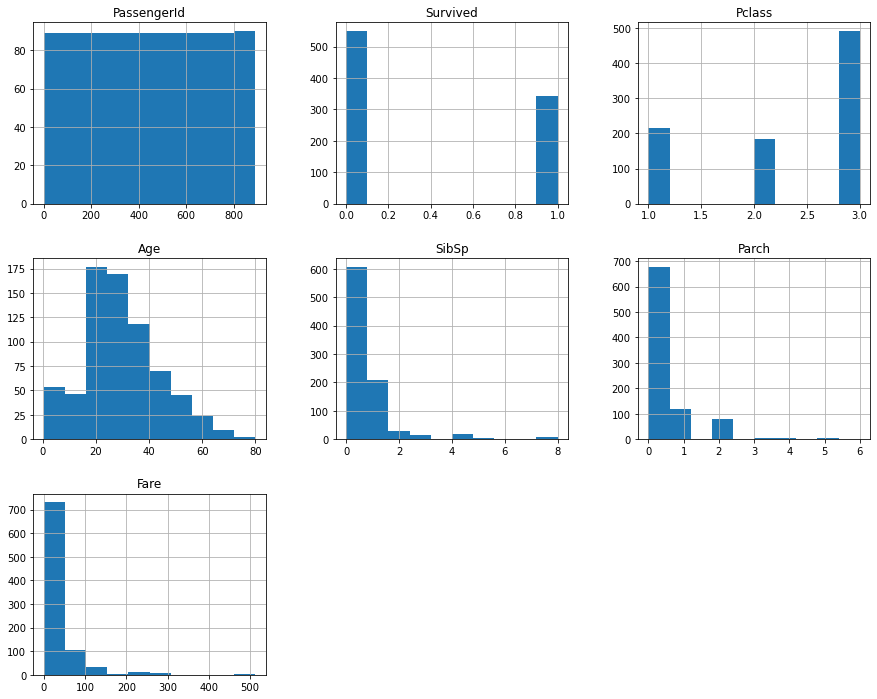

In [571]:
# plot the frequency distributions
training_data.hist(figsize=(15,12))

We can see that 'Fare' has outliers, we'll get rid of them later on...

### Did the port embarked from have any influence on survival? <a id='port' ><a/>

In [572]:
# get the unique vlaues for the ports that the ship sailed from
training_data['Embarked'].unique()

array(['S', 'C', 'Q', nan], dtype=object)

In [573]:
# remind ourselves how many people survived
(training_data['Survived']==1).sum()

342

In [574]:
# find the logic to get values for survival rates based on what port the passenger sailed from
((training_data['Embarked']== 'S') & (training_data['Survived']==1)).sum()

217

In [575]:
y = []

for i in training_data['Embarked'].unique():
    survived = ((training_data['Embarked']== i) & (training_data['Survived']==1)).sum()
    y.append(survived)
    print(f"{i}: {survived}")
    

S: 217
C: 93
Q: 30
nan: 0


The output sums to 340, meaning there are 2 missing values. This might be because _nan_ isn't a string in our array of unqiue ports. Let's change it to 'nan'.

In [576]:
ports = list(training_data['Embarked'].unique())
ports

['S', 'C', 'Q', nan]

In [577]:
# replace nan with 'NaN'
ports[3] = 'NaN'
ports

['S', 'C', 'Q', 'NaN']

In [578]:
# run the loop again to see if the 2 missing values fall under NaN
survived = []

for i in training_data['Embarked'].unique():
    survivors = ((training_data['Embarked']== i) & (training_data['Survived']==1)).sum()
    survived.append(survivors)
    
survived

[217, 93, 30, 0]

It made no difference.... perhaps those 2 are the captain and vice-captain? As it is only 2 entries I'm not too concerned so let's carry on...

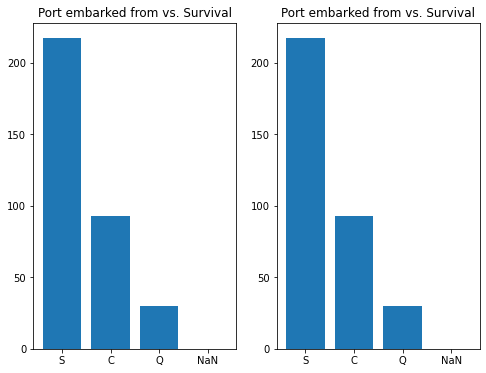

In [579]:
# check whether port embarked from has anything interesting to reveal

# make 2 graphs to practice with matplotlib
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 6))

ax[0].bar(x=ports, height=survived)
ax[0].set_title("Port embarked from vs. Survival")

ax[1].bar(x=ports, height=survived)
ax[1].set_title("Port embarked from vs. Survival")

plt.show()

* The bar chart reveals that the majority of the survivors embarked from Southampton. 
* Were the passengers that embarked from Southampton all in the same section of the ship, or was the section they stayed in determined by their ticket? 
* Perhaps those who embarked from Southamption were of a certain socio-economic class meaning they had a similarly priced ticket and therfore were in the same section of the ship. 
* But this would assume that passengers were all in their rooms when the ship crashed.
* Should Embarked be kept as a feature or could this be a red herring that will lead to the system learning incorrectly?? I'm going to keep it in, which will mean we have to encode the letters to 1s and 0s later on. Remember that these will be labelled 0,1,3 but they are not related (not ordinal) so consider this when encoding!

# Split the data into training and test sets <a id='train_test_split' ><a/>

### Stratified Sampling <a id='stratified' ><a/>
* Stratified sampling divides the data into homogenous sub-groups called strata, and the right number of isntances are sampled from each stratum to ensure that the test set is reperesentative of the overall population. If we just did random sampling then we run the risk of the test set being skewed or biased. If we know that one attribute is very important when predicting the outcome then we want to ensure that the test set is representative of the ratios within the dataset.
* Going to use stratified sampling based on sex to ensure we get a representative sample from each sex as it would seem that sex played an important role in who survived.

In [580]:
# use StratifiedShuffleSplit() to split by sex
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(training_data, training_data["Sex"]):
    strat_train_set = training_data.loc[train_index]
    strat_test_set = training_data.loc[test_index]

In [581]:
# create a copy of the now stratified training set so we can play with it without affecting the training set
training_data = strat_train_set.copy()
training_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
788,789,1,3,"Dean, Master. Bertram Vere",male,1.0,1,2,C.A. 2315,20.5750,NaN,S
347,348,1,3,"Davison, Mrs. Thomas Henry (Mary E Finck)",female,NaN,1,0,386525,16.1000,NaN,S
629,630,0,3,"O'Connell, Mr. Patrick D",male,NaN,0,0,334912,7.7333,NaN,Q
734,735,0,2,"Troupiansky, Mr. Moses Aaron",male,23.0,0,0,233639,13.0000,NaN,S
106,107,1,3,"Salkjelsvik, Miss. Anna Kristine",female,21.0,0,0,343120,7.6500,NaN,S


In [582]:
# see if the stratified sampling has worked by looking at the sex category proportions in the test set
strat_test_set['Sex'].value_counts()/len(strat_test_set)

male      0.648045
female    0.351955
Name: Sex, dtype: float64

In [583]:
# check this against the sex category proportions in the full training dataset
training_data['Sex'].value_counts()/len(training_data['Sex'])

male      0.647472
female    0.352528
Name: Sex, dtype: float64

It has worked! We can now clean and prepare the data for our machine learning algorithm whilst being comfortable that the model will be training on a fair and representative sample, based on the sex of each passenger.

## Separate the predictors and the labels <a id='separate_predictors' ><a/>
* We'll separate the predictors and the labels, since we don't necessarily want to apply the same transformations to the predictors and the target values.

In [584]:
# create a training set without the predictors
# note that .drop() creates a copy - it won't affect the strat_train_set
training_data = strat_train_set.drop('Survived', axis=1)

# create a dataset with just the training labels
training_data_labels = strat_train_set['Survived'].copy()

In [585]:
# check our dataset
training_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
788,789,3,"Dean, Master. Bertram Vere",male,1.0,1,2,C.A. 2315,20.5750,NaN,S
347,348,3,"Davison, Mrs. Thomas Henry (Mary E Finck)",female,NaN,1,0,386525,16.1000,NaN,S
629,630,3,"O'Connell, Mr. Patrick D",male,NaN,0,0,334912,7.7333,NaN,Q
734,735,2,"Troupiansky, Mr. Moses Aaron",male,23.0,0,0,233639,13.0000,NaN,S
106,107,3,"Salkjelsvik, Miss. Anna Kristine",female,21.0,0,0,343120,7.6500,NaN,S


In [586]:
# check that we have stored the labels correctly
training_data_labels.head()

788    1
347    1
629    0
734    0
106    1
Name: Survived, dtype: int64

In [587]:
# remind ourselves of non-null values for each column
training_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 788 to 261
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Pclass       712 non-null    int64  
 2   Name         712 non-null    object 
 3   Sex          712 non-null    object 
 4   Age          578 non-null    float64
 5   SibSp        712 non-null    int64  
 6   Parch        712 non-null    int64  
 7   Ticket       712 non-null    object 
 8   Fare         712 non-null    float64
 9   Cabin        164 non-null    object 
 10  Embarked     710 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 66.8+ KB


# Data Cleaning <a id='cleaning' ><a/>

### Missing Values (Feature imputation) <a id='missing_values' ><a/>
* A machine learning model can’t learn on data that isn’t there!
* Single imputation: Fill with mean or median of the column.
* Multiple imputations: Model other missing values and with what your model finds.
* Many more, such as random imputation, last observation carried forward (for time series), moving window, and most frequent value.

In [588]:
# Cabin had 687 missing values and Age has 177 missing values - let's check what % of all observations this is
cabin_mv = (687/891)*100
cabin_mv = round(cabin_mv, 1)
age_mv = (177/891)*100
age_mv = round(age_mv, 1)

print(f"Cabin missing values: {cabin_mv}% of all observations")
print(f"Age missing values: {age_mv}% of all observations")

Cabin missing values: 77.1% of all observations
Age missing values: 19.9% of all observations


* Cabin is missing well over 20% so let's drop this column when it comes to feature selection. 
* 'Age' will be kept and the missing values will be filled with the median using the Scikit-learn class _SimpleImputer()_ 

In [589]:
# Cabin is to be dropped
# passenger ID and Name are unlikely to have any bearing on survival chances so we'll drop these columns
# Ticket had over 600/891 unique values so we drop that too
training_data_cleaned = training_data.drop(columns=['PassengerId', 'Name', 'Cabin', 'Ticket'], axis=1)
training_data_cleaned.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
788,3,male,1.0,1,2,20.5750,S
347,3,female,NaN,1,0,16.1000,S
629,3,male,NaN,0,0,7.7333,Q
734,2,male,23.0,0,0,13.0000,S
106,3,female,21.0,0,0,7.6500,S


## Numerical attributes <a id='numerical' ><a/>
* The data is a combination of numerical and categorical data.
* The numerical (continuous variables) are: Age, SibSp, Parch, and Fare. 
* The categorical columns are: Pclass (a proxy for socio-economic class), Sex and Embarked.
* The numerical and categorical data will be cleaned and pre-processed slightly differently so the plan is to split the dataframe into numerical and categorical variables and then join them back together once the pre-processing has taken place.

### Missing Values <a id='missing_valuesl' ><a/>

In [590]:
# go through the steps to create a simple imputer and fill missing values and then later on we'll (possibly) create a full transformer
imputer_median = SimpleImputer(strategy='median')

We can't apply our imputer median values to categorical data so for now we just want to work with the numercial data. We'll split up the numerical and categorical data to apply cleaning and pre-processing and then join them back together to create one full training data set.

In [591]:
# create a copy of the data with only the numerical features, which in this case is all but 'Embarked' and 'Sex'
training_data_num = training_data_cleaned.drop(columns=['Pclass', 'Embarked', 'Sex'], axis=1)

In [592]:
# fit the imputer instance
imputer_median.fit(training_data_num)

SimpleImputer(strategy='median')

In [593]:
# check the output (this will give us the median value for each attribute)
imputer_median.statistics_

array([28.     ,  0.     ,  0.     , 14.45625])

In [594]:
# compare to getting the median in another way
training_data_num.median().values

array([28.     ,  0.     ,  0.     , 14.45625])

In [595]:
# check numerical null values
training_data_num.isnull().sum()

Age      134
SibSp      0
Parch      0
Fare       0
dtype: int64

In [596]:
# create a dataset with the missing values populated
X = imputer_median.transform(training_data_num)

In [597]:
X

array([[ 1.    ,  1.    ,  2.    , 20.575 ],
       [28.    ,  1.    ,  0.    , 16.1   ],
       [28.    ,  0.    ,  0.    ,  7.7333],
       ...,
       [28.    ,  0.    ,  0.    , 26.55  ],
       [49.    ,  1.    ,  0.    , 89.1042],
       [ 3.    ,  4.    ,  2.    , 31.3875]])

In [598]:
# create a pandas dataframe out of our transformed dataset (medians replacing missing values)
training_data_numerical = pd.DataFrame(data=X, columns=training_data_num.columns, index=training_data_num.index)
training_data_numerical.head()

,Age,SibSp,Parch,Fare
788,1.0,1.0,2.0,20.5750
347,28.0,1.0,0.0,16.1000
629,28.0,0.0,0.0,7.7333
734,23.0,0.0,0.0,13.0000
106,21.0,0.0,0.0,7.6500


In [599]:
# check to see if there are any null values (the 134 null values in Age should now be the median so there should be 
# 0 null values)
training_data_numerical.isnull().sum()

Age      0
SibSp    0
Parch    0
Fare     0
dtype: int64

## Outliers <a id='outliers' ><a/>

array([[<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'SibSp'}>],
       [<AxesSubplot:title={'center':'Parch'}>,
        <AxesSubplot:title={'center':'Fare'}>]], dtype=object)

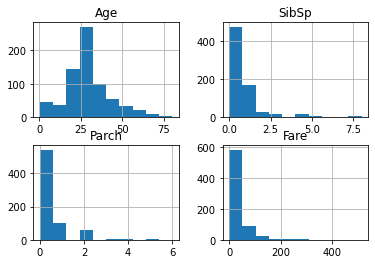

In [600]:
# remind ourselves of the distribution of the numerical data
training_data_numerical.hist()

* There are various ways to deal with outliers; the method used to deal with them is usually determined by the distribution of the feature.
* _Age_ and _Fare_ have outliers and both have positively skewed distributions...
* Interquartile range based filtering is often used when the data is skewed so we'll use this to eliminate outliers in an attempt to avoid overfitting.

https://www.analyticsvidhya.com/blog/2021/05/feature-engineering-how-to-detect-and-remove-outliers-with-python-code/

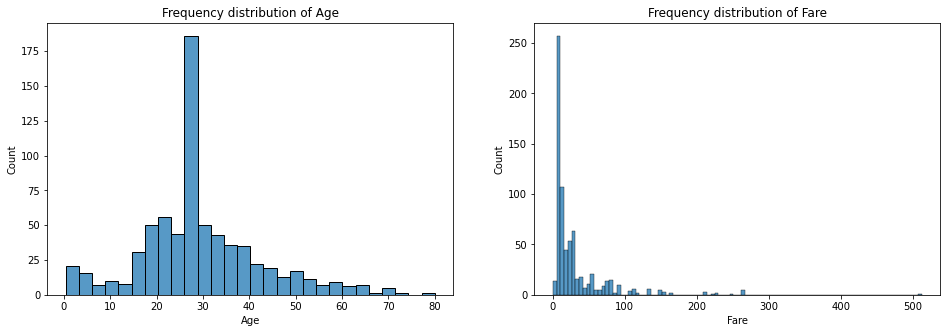

In [601]:
# plot the distribution for the features
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
sns.histplot(training_data_numerical['Age'])
plt.title("Frequency distribution of Age")
plt.subplot(1,2,2)
sns.histplot(training_data_numerical['Fare'])
plt.title("Frequency distribution of Fare")
plt.show()

<AxesSubplot:xlabel='Age'>

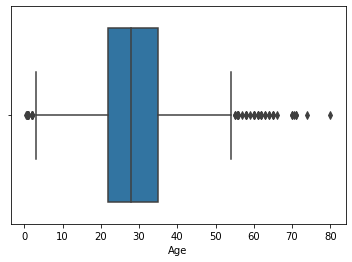

In [602]:
# form a box plot for the skewed features
# boxplot of Age
sns.boxplot(x=training_data_numerical['Age'])

<AxesSubplot:xlabel='Fare'>

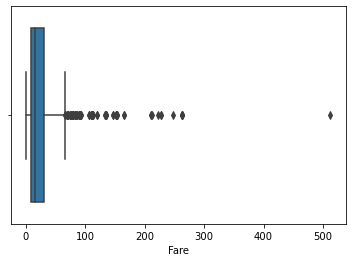

In [603]:
# boxplot of Fare
sns.boxplot(x=training_data_numerical['Fare'])

In [604]:
# find the Inter-quartile range (the difference between the 75th and 25th percentile, or the 3rd and 1st quarter)
age_percentile_25 = training_data_numerical['Age'].quantile(0.25)
age_percentile_75 = training_data_numerical['Age'].quantile(0.75)
age_iqr = age_percentile_75 - age_percentile_25

fare_percentile_25 = training_data_numerical['Fare'].quantile(0.25)
fare_percentile_75 = training_data_numerical['Fare'].quantile(0.75)
fare_iqr = fare_percentile_75 - fare_percentile_25

In [605]:
# find the upper and lower limit
# A data point is commonly deemed an outlier if it is more than 1.5 times above the third quartile or below 
# the first quartile. 
age_upper_limit = age_percentile_75 + (1.5 * age_iqr)
age_lower_limit = age_percentile_25 - (1.5 * age_iqr)

fare_upper_limit = fare_percentile_75 + (1.5 * fare_iqr)
fare_lower_limit = fare_percentile_25 - (1.5 * fare_iqr)

In [606]:
# find the outliers
print(training_data_numerical[training_data_numerical['Age'] > age_upper_limit])
print(f"\n ------------- \n")
print(training_data_numerical[training_data_numerical['Age'] < age_lower_limit])

      Age  SibSp  Parch      Fare
280  65.0    0.0    0.0    7.7500
252  62.0    0.0    0.0   26.5500
366  60.0    1.0    0.0   75.2500
268  58.0    0.0    1.0  153.4625
326  61.0    0.0    0.0    6.2375
492  55.0    0.0    0.0   30.5000
94   59.0    0.0    0.0    7.2500
275  63.0    1.0    0.0   77.9583
493  71.0    0.0    0.0   49.5042
170  61.0    0.0    0.0   33.5000
467  56.0    0.0    0.0   26.5500
11   58.0    0.0    0.0   26.5500
174  56.0    0.0    0.0   30.6958
15   55.0    0.0    0.0   16.0000
483  63.0    0.0    0.0    9.5875
456  65.0    0.0    0.0   26.5500
647  56.0    0.0    0.0   35.5000
438  64.0    1.0    4.0  263.0000
587  60.0    1.0    1.0   79.2000
829  62.0    0.0    0.0   80.0000
672  70.0    0.0    0.0   10.5000
684  60.0    1.0    1.0   39.0000
116  70.5    0.0    0.0    7.7500
33   66.0    0.0    0.0   10.5000
625  61.0    0.0    0.0   32.3208
772  57.0    0.0    0.0   10.5000
96   71.0    0.0    0.0   34.6542
152  55.5    0.0    0.0    8.0500
54   65.0    0

In [607]:
# count how many entries are deemed to be outliers at upper end
training_data_numerical[training_data_numerical['Age'] > age_upper_limit].value_counts().sum()

37

In [608]:
# count how many entries are deemed to be outliers at lower end
training_data_numerical[training_data_numerical['Age'] < age_lower_limit].value_counts().sum()

18

* Removing outliers from the Age variable would result in losing 37 + 18 = 55 entries.
* The ages below the 25th percentile are mostly babies and I wonder if this may or may not play an improtant role in survival.
* Perhaps it is worth training a model with and without outliers for Age??

In [609]:
# find the outliers
print(training_data_numerical[training_data_numerical['Fare'] > fare_upper_limit])
print(f"\n ------------- \n")
print(training_data_numerical[training_data_numerical['Fare'] < fare_lower_limit])

       Age  SibSp  Parch      Fare
763  36.00    1.0    2.0  120.0000
334  28.00    1.0    0.0  133.6500
61   38.00    0.0    0.0   80.0000
201  28.00    8.0    2.0   69.5500
305   0.92    1.0    2.0  151.5500
..     ...    ...    ...       ...
373  22.00    0.0    0.0  135.6333
306  28.00    0.0    0.0  110.8833
820  52.00    1.0    1.0   93.5000
698  49.00    1.0    1.0  110.8833
453  49.00    1.0    0.0   89.1042

[93 rows x 4 columns]

 ------------- 

Empty DataFrame
Columns: [Age, SibSp, Parch, Fare]
Index: []


In [610]:
# count how many entries are deemed to be outliers at lower end
training_data_numerical[training_data_numerical['Fare'] > fare_upper_limit].value_counts().sum()

93

In [611]:
# count how many entries are deemed to be outliers at lower end
training_data_numerical[training_data_numerical['Fare'] < fare_lower_limit].value_counts().sum()

0

* Removing outliers from the Fare variable would result in losing 93 entries, all of which are above the 75th percentile (none are below the 25th percentile).

#### Decide what outliers to trim
* Trim the outliers from Fare but keep age. The Fare tail is long but the Age one isn't very.

In [612]:
# check the shape
training_data_numerical.shape

(712, 4)

In [613]:
# trim the Fare outliers
training_data_numerical = training_data_numerical[training_data_numerical['Fare'] < fare_upper_limit]
training_data_numerical.head()

,Age,SibSp,Parch,Fare
788,1.0,1.0,2.0,20.5750
347,28.0,1.0,0.0,16.1000
629,28.0,0.0,0.0,7.7333
734,23.0,0.0,0.0,13.0000
106,21.0,0.0,0.0,7.6500


In [614]:
# check the shape of the data after trimming the dataset to only include rows where the Fare was less than the upper limit
# the rows should equal 712 minus 93 = 619
training_data_numerical.shape

(619, 4)

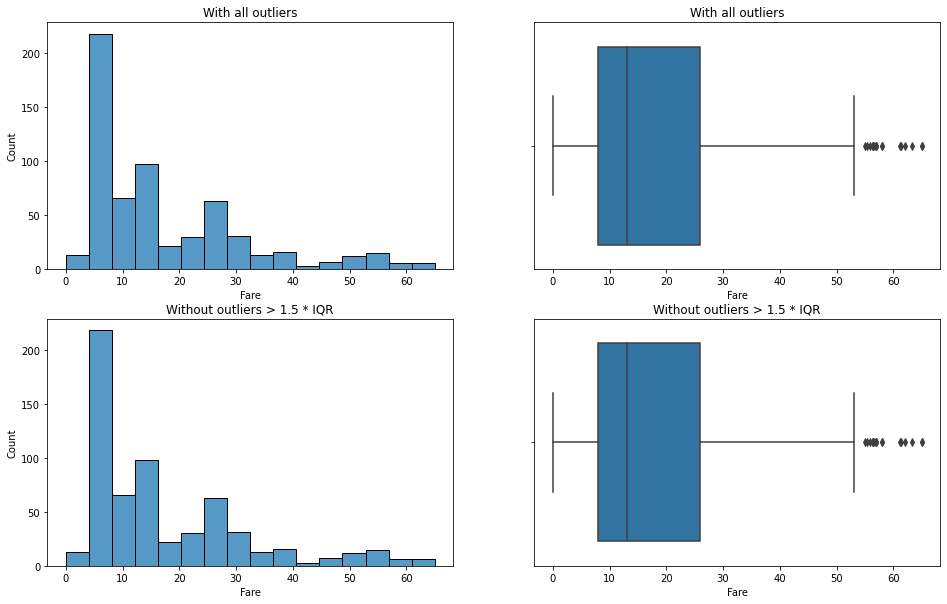

In [615]:
# compare the plots after trimming
plt.figure(figsize=(16,10))
plt.subplot(2,2,1)
sns.histplot(x=training_data_numerical['Fare'])
plt.title("With all outliers")
plt.subplot(2,2,2)
sns.boxplot(x=training_data_numerical['Fare'])
plt.title("With all outliers")
plt.subplot(2,2,3)
sns.histplot(x=training_data_numerical['Fare'])
plt.title("Without outliers > 1.5 * IQR")
plt.subplot(2,2,4)
sns.boxplot(x=training_data_numerical['Fare'])
plt.title("Without outliers > 1.5 * IQR")

plt.show()

### Function for removing outliers <a id='outlier_removal_function' ><a/>

In [616]:
def outlier_removal(df, columns_to_find_outliers):
    
    """
    
    Function that removes outliers from a dataframe. 
    This function requires, as arguments, the dataframe and a list of the columns that the user would like to remove the 
    outliers from.
    The function will gather the indices of the specified columns and then remove these rows.
    
    """
    
    # take the features we want to find outliers in and create a list so it can be looped through
    columns = list(columns_to_find_outliers)
    
    # create an empty list to store the output indices from each column
    index_list = []
    
    for i in columns:

        # set the quartiles and interquartile range
        q1, q3 = df[i].quantile(0.25), df[i].quantile(0.75)
        iqr = q3 - q1
        # set the lower and upper bounds
        lower_bound = q1 - (iqr * 1.5)
        upper_bound = q3 + (iqr * 1.5) 

        # get the indices of the outliers in the column
        outlier_indices = df.index[(df[i] < lower_bound) | (df[i] > upper_bound)]

        # count the number of outliers (for validation sake)
        count = len(outlier_indices)

        # append the outlier indices to a list
        index_list.extend(outlier_indices)

        # update user on how many outliers were in each column
        print(f"\nNumber of outliers in column '{i}': {count}\n"
              f"Indices of outliers in column '{i}': {outlier_indices}\n"
             f"Indices of rows that contain outliers and that will be removed: {index_list}")
        
    # delete the rows that contain the outliers / would it be better to replace with the median??
    df = df.drop(labels=index_list)
    return df

## Scale or standardize the data <a id='scale' ><a/>
* This generally leads to more accurate models. 
* Note that - as with all the transformations -  we only apply the scaler to the training data (by now we should have split the data).

In [617]:
# define standard scaler
scaler = StandardScaler()

In [618]:
# retrieve just the numeric values as the scaler will need to take an array not a dataframe
numerical_data_to_scale = training_data_numerical.values[:, :]

In [619]:
# standardise the data
training_data_numerical_scaled = scaler.fit_transform(numerical_data_to_scale)

In [620]:
training_data_numerical_scaled = pd.DataFrame(training_data_numerical_scaled, 
                                              columns=training_data_numerical.columns,
                                             index=training_data_numerical.index)
training_data_numerical_scaled

,Age,SibSp,Parch,Fare
788,-2.135627,0.570403,2.138070,0.194308
347,-0.048424,0.570403,-0.424302,-0.130623
629,-0.048424,-0.496302,-0.424302,-0.738131
734,-0.434943,-0.496302,-0.424302,-0.355715
106,-0.589551,-0.496302,-0.424302,-0.744179
...,...,...,...,...
668,1.111133,-0.496302,-0.424302,-0.715135
263,0.879222,-0.496302,-0.424302,-1.299647
628,-0.203032,-0.496302,-0.424302,-0.726332
711,-0.048424,-0.496302,-0.424302,0.628154


## Categorical attributes <a id='categorical' ><a/>
* Categorical attributes need to be converted into an understandable format for the machine learning algorithm: 1s and 0s.

#### One hot encode the Pclass, port embarked from and sex <a id='one_hot' ><a/>

In [621]:
# our categorical attributes aren't related (they're not ordinal) so we can use one-hot encoding
# first we need to store the categorical data in a variable
training_data_cat = training_data[['Pclass', 'Embarked', 'Sex']]
training_data_cat.head()

,Pclass,Embarked,Sex
788,3,S,male
347,3,S,female
629,3,Q,male
734,2,S,male
106,3,S,female


In [622]:
# create an instance of OneHotEncoder()
cat_encoder = OneHotEncoder()

# perform the encoding (fit) and then transform the dataset
training_data_cat_1hot = cat_encoder.fit_transform(training_data_cat)

# check the output
training_data_cat_1hot

<712x9 sparse matrix of type '<class 'numpy.float64'>'
	with 2136 stored elements in Compressed Sparse Row format>

One hot encoding outputs a sparse matrix. We can convert this to a 2D array. 

### Reminder about sparse matrix

Sparse matrices are very useful when we have categorical attributes with thousands of categories. After one-hot encoding, we get a matrix with thosuands of columns, and the matrix is full of 0s except for a single 1 per row. Using up tonnes of memory to store zeros would be very wasteful, so instead a **sparse_matrix** only stores the location of the non-zero elements. We can use it like a normal 2D array, but if we really want to, we can convert it to a - dense - NumPy array, by calling the _toarray()_ method...

In [623]:
# one hot encoding outputs a sparse matrix, we can convert to a 2D array
training_data_cat_1hot = training_data_cat_1hot.toarray()

In [624]:
# get a list of categories wit the encoder's categories_
cat_encoder.categories_

[array([1, 2, 3]),
 array(['C', 'Q', 'S', nan], dtype=object),
 array(['female', 'male'], dtype=object)]

In [625]:
# concatenate the arrays and then convert into a list so we can use for column headings
np.concatenate(cat_encoder.categories_)

array([1, 2, 3, 'C', 'Q', 'S', nan, 'female', 'male'], dtype=object)

In [626]:
# convert to list
column_list = list(np.concatenate(cat_encoder.categories_))
column_list

[1, 2, 3, 'C', 'Q', 'S', nan, 'female', 'male']

In [628]:
training_data_categorical = pd.DataFrame(training_data_cat_1hot,
                                         columns=column_list,
                                         index=training_data_cat.index)

training_data_categorical

,1,2,3,C,Q,S,NaN,female,male
788,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
347,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
629,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
734,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
106,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...
263,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
628,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
711,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
453,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [631]:
# quick check shows that the output above is correct in terms of headings and one-hot encoding
training_data_cat.head()

,Pclass,Embarked,Sex
788,3,S,male
347,3,S,female
629,3,Q,male
734,2,S,male
106,3,S,female


The output shows that our one-hot encoded dataframe should have: 

Index 788: a 1 for 3, S and male

Index 347: a 1 for 3, S and female

Index 629: a 1 for 3, Q and male

# Join the numerical and categorical data <a id='join' ><a/>
This will give us a full training data set that has been cleaned and transformed and is ready for the machine learning algorithm.

In [634]:
# show numerical dataframe
training_data_numerical_scaled.head()

,Age,SibSp,Parch,Fare
788,-2.135627,0.570403,2.138070,0.194308
347,-0.048424,0.570403,-0.424302,-0.130623
629,-0.048424,-0.496302,-0.424302,-0.738131
734,-0.434943,-0.496302,-0.424302,-0.355715
106,-0.589551,-0.496302,-0.424302,-0.744179


In [633]:
# show categorical dataframe
training_data_categorical.head()

,1,2,3,C,Q,S,NaN,female,male
788,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
347,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
629,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
734,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
106,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0


In [637]:
training_data_numerical_scaled.shape

(619, 4)

In [638]:
training_data_categorical.shape

(712, 9)

#### Note on different shapes

We dropped a number of rows from the numerical data so the categorical dataframe has more rows and these rows will not contain any numerical data; this is ok, we'll join the dataframes and then drop the rows that have missing values in the numerical data columns so that we are only working with complete rows.

**Update**

When joining, because it joins on the left and right index, the indices where there isn't a join are obviously dropped so there are no null values to deal with.

In [640]:
# join the dataframes
training_data_prepared = pd.merge(training_data_numerical_scaled, training_data_categorical, 
                                  left_index=True, right_index=True)
training_data_prepared.head()

,Age,SibSp,Parch,Fare,1,2,3,C,Q,S,NaN,female,male
788,-2.135627,0.570403,2.138070,0.194308,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
347,-0.048424,0.570403,-0.424302,-0.130623,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
629,-0.048424,-0.496302,-0.424302,-0.738131,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
734,-0.434943,-0.496302,-0.424302,-0.355715,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
106,-0.589551,-0.496302,-0.424302,-0.744179,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0


In [642]:
training_data_prepared.isnull().sum()

Age       0
SibSp     0
Parch     0
Fare      0
1         0
2         0
3         0
C         0
Q         0
S         0
NaN       0
female    0
male      0
dtype: int64

In [644]:
training_data_prepared.shape

(619, 13)

The dataset is now ready for training!

## Select model and train it <a id='model' ><a/>
Explore many different models and shortlist the best ones (different problems require different type of models (algorithms))
1. Choose the type of model (supervised, unsupervised, classification, regression etc.)
2. Fit the model
3. Evaluate the models using cross-validation or Scikit-Learn’s K-fold cross validation and shortlist the best ones

1. Logistic regression model - fit it and evaluate it with cross validation.
2. Decision tree regressor - fit it and evaluate it with cross validation.
3. Random forest regressor - fit and evaluate with cross validation

## Fine tune model <a id='fine_tune' ><a/>
https://realpython.com/logistic-regression-python/

https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/

https://machinelearningmastery.com/hyperparameter-optimization-with-random-search-and-grid-search/

1. Tune the hyperparameters using GridSearchCV or RandomSearchCV
2. Once you know the set of hyperparameters that achieve the best result, you can then define a new model, set the values of each hyperparameter, then fit the model on all available data. This model can then be used to make predictions on new data


## Test model on test set <a id='test' ><a/>
1. Apply any transformations to the test set (creating functions helps with this for when brand new data is fed to the model)
2. Test the model on the test data